### Классификация изображений художников разного стиля с использованием `PyTorch`

Импорт библиотек:

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
#import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import precision_recall_fscore_support

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Определяем трансформацию изображений: отдельно для тренировочного набора с аугментацией данных и отдельно для тестового и валидационного.

In [2]:
# define default transormation

val_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# randop crop
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomRotation(30),
    #transforms.GaussianNoise(0.1),

    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    #transforms.Normalize()
    #transforms.Normalize(mean, std)

])

Загрузка изображений, которые хранятся в директории `images` 

In [3]:
image_dataset = torchvision.datasets.ImageFolder('images', transform=val_transform)

Разбиваем изображения на трейновый, валидационный и тестовый набор (70%, 20%, 10%)

In [4]:
train_size = int(0.7 * len(image_dataset))
val_size = int(0.2 * len(image_dataset))
test_size = len(image_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size, test_size])
# realize data augmentation for train set
train_dataset.dataset.transform = train_transform


In [5]:
# загрузка данных соответствующего размера
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
print("Train set size: {:}, validation set size: {:}, test set size: {:}".format(train_size, val_size, test_size))

print(train_size)
print(val_size)
print(test_size)
print(train_dataset.dataset)

Train set size: 995, validation set size: 284, test set size: 143
995
284
143
Dataset ImageFolder
    Number of datapoints: 1422
    Root location: images
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


Проверим результат разбиения по классам

In [7]:
def count_classes(dataloader):
    labels_count = defaultdict(int)
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        for label in labels:
            labels_count[label.item()] += 1
    return(labels_count)
# data = count_classes(train_dataloader)
# print(count_classes(train_dataloader))
# labels_count = defaultdict(int)
# for i, data in enumerate(test_dataloader, 0):
#     inputs, labels = data
#     for label in labels:
#         labels_count[label.item()] += 1
        
        
# val_count = defaultdict(int)

# for i, data in enumerate(val_dataloader, 0):
#     inputs, labels = data
#     for label in labels:
#         val_count[label.item()] += 1
# print(val_count)
#     return(labels_count)
data = {'Train set': count_classes(train_dataloader),
        'Validation set': count_classes(val_dataloader),
        'Test set': count_classes(test_dataloader)}
print(data)

{'Train set': defaultdict(<class 'int'>, {2: 162, 1: 269, 4: 150, 0: 40, 3: 154, 5: 76, 6: 47, 7: 97}), 'Validation set': defaultdict(<class 'int'>, {2: 51, 4: 50, 7: 29, 6: 19, 5: 22, 1: 61, 0: 17, 3: 35}), 'Test set': defaultdict(<class 'int'>, {0: 8, 1: 35, 7: 13, 2: 27, 5: 19, 6: 9, 3: 14, 4: 18})}


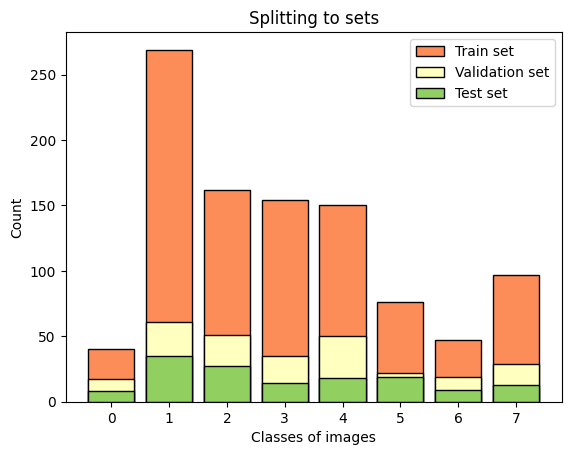

In [8]:
colors = ['#fc8d59', '#ffffbf', '#91cf60']

for i, group in enumerate(data.keys()):
    keys = list(data[group].keys())
    values = list(data[group].values())
    plt.bar(keys, values, edgecolor='black', color=colors[i], label=group)

plt.xlabel('Classes of images')
plt.ylabel('Count')
plt.title('Splitting to sets')
plt.legend()
plt.show()

In [9]:
model = torchvision.models.resnet18(weights=True)
#model = torchvision.models.resnet50(weights=True)

model.fc = nn.Linear(512, len(image_dataset.classes))
#model.fc.register_forward_hook(lambda m, inp, out: nn.Softmax(out))
#model.fc = nn.Sequential(
 #   nn.Linear(512, len(image_dataset.classes)),
  #  nn.Softmax())
#model.fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.2, training=m.training))


C:\Users\elena\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# from torchvision.models.feature_extraction import get_graph_node_names
# from torchvision.models import resnet50

# train_nodes, eval_nodes = get_graph_node_names(resnet50())
# print(train_nodes)
# print(eval_nodes)

Выбираю функцию ошибки CrossEntropyLoss, поскольку у нас несколько классов


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters())
# optimizer = optim.RMSprop(model.parameters()) # this optimizer functioned really bad

In [13]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [14]:
def validate(model, dataloader, criterion):
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        val_loss = running_loss / len(dataloader)
        val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

In [15]:
num_epochs = 15
best_accuracy = 0
best_loss = float('inf')
best_epoch = 0
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Record the loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate the average loss and accuracy for the epoch
    train_loss = running_loss / len(train_dataloader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validate the model
    val_loss, val_accuracy = validate(model, val_dataloader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print("Epoch {}/{} - Train Loss: {:.4f} - Train Accuracy: {:.2f}% - Val Loss: {:.4f} - Val Accuracy: {:.2f}%".format(
        epoch + 1, num_epochs, train_loss, train_accuracy, val_loss, val_accuracy))
    if val_accuracy > best_accuracy or (val_accuracy == best_accuracy and val_loss < best_loss):
        best_accuracy = val_accuracy
        best_loss = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

Epoch 1/25 - Train Loss: 6.8693 - Train Accuracy: 20.90% - Val Loss: 4.9395 - Val Accuracy: 21.48%
Epoch 2/25 - Train Loss: 2.9213 - Train Accuracy: 23.22% - Val Loss: 2.8642 - Val Accuracy: 19.37%
Epoch 3/25 - Train Loss: 2.4598 - Train Accuracy: 23.32% - Val Loss: 4.1407 - Val Accuracy: 6.34%
Epoch 4/25 - Train Loss: 2.3377 - Train Accuracy: 24.02% - Val Loss: 3.2127 - Val Accuracy: 10.92%
Epoch 5/25 - Train Loss: 2.2196 - Train Accuracy: 23.72% - Val Loss: 2.6492 - Val Accuracy: 19.01%
Epoch 6/25 - Train Loss: 2.2120 - Train Accuracy: 25.83% - Val Loss: 2.8735 - Val Accuracy: 19.37%
Epoch 7/25 - Train Loss: 2.1360 - Train Accuracy: 26.83% - Val Loss: 2.5507 - Val Accuracy: 12.68%
Epoch 8/25 - Train Loss: 2.0693 - Train Accuracy: 24.02% - Val Loss: 2.5199 - Val Accuracy: 20.42%
Epoch 9/25 - Train Loss: 1.9999 - Train Accuracy: 26.73% - Val Loss: 2.2413 - Val Accuracy: 16.55%
Epoch 10/25 - Train Loss: 1.9429 - Train Accuracy: 24.32% - Val Loss: 2.0922 - Val Accuracy: 22.89%
Epoch 11/2

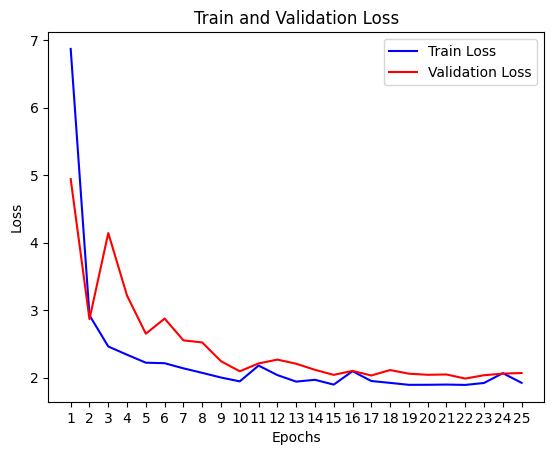

In [16]:
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, 'b', label='Train Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs+1))
plt.legend()
plt.show()


#plt.plt(train_losses, val_losses)

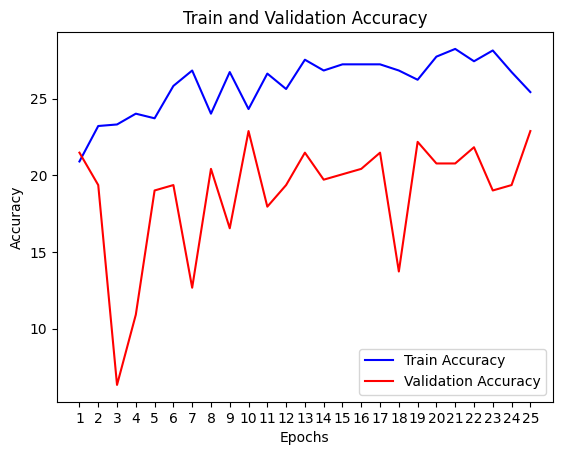

In [17]:
plt.plot(epochs, train_accuracies, 'b', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xticks(range(1, num_epochs+1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
test_loss, test_accuracy = validate(model, test_dataloader, criterion)
print(best_epoch+1)
print("Test Loss: {:.4f}, Test Accuracy: {:.2f}% in the epoch {:}".format(test_loss, test_accuracy, best_epoch+1))

25
Test Loss: 2.1112, Test Accuracy: 24.48% in the epoch 25


Почему использовали F1 score взвешенный

In [19]:
# Initialize the confusion matrix

confusion_matrix = torch.zeros(len(image_dataset.classes), len(image_dataset.classes), dtype=torch.int64)

# Initialize the lists to store the true labels and predicted labels for the test set
true_labels = []
pred_labels = []

# Evaluation mode
model.eval()

# Set the gradient computation to be off
with torch.no_grad():
    # Iterate over the test data
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        
        # Append the true labels and predicted labels to the lists
        true_labels.extend(labels.tolist())
        pred_labels.extend(preds.tolist())
        
        # Increment the count in the corresponding cells of the confusion matrix
        for t, p in zip(labels, preds):
            confusion_matrix[t, p] += 1

# Compute the precision, recall and f1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')

# Print the test loss, test accuracy and f1-score
print("Test Loss: {:.4f} - Test Accuracy: {:.2f}% - Test F1-Score: {:.2f}".format(test_loss, test_accuracy, f1_score))


Test Loss: 2.1112 - Test Accuracy: 24.48% - Test F1-Score: 0.17


C:\Users\elena\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
confusion_matrix

tensor([[ 0,  5,  3,  0,  0,  0,  0,  0],
        [ 0, 19, 16,  0,  0,  0,  0,  0],
        [ 0,  7, 20,  0,  0,  0,  0,  0],
        [ 0,  5,  9,  0,  0,  0,  0,  0],
        [ 0,  7, 11,  0,  0,  0,  0,  0],
        [ 0,  4, 15,  0,  0,  0,  0,  0],
        [ 0,  4,  5,  0,  0,  0,  0,  0],
        [ 0, 13,  0,  0,  0,  0,  0,  0]])

In [21]:
print(precision)
print(recall)

0.12046201425157121
0.2727272727272727


In [22]:
print(train_losses)
print(train_accuracies)
print(val_losses)
print(val_accuracies)

[6.869304668158293, 2.9213353134691715, 2.4597710371017456, 2.3376547917723656, 2.219617184251547, 2.2120026238262653, 2.1360025741159916, 2.069310702383518, 1.9998789429664612, 1.942925214767456, 2.176959350705147, 2.0361732318997383, 1.9393807835876942, 1.9661020301282406, 1.894998224452138, 2.09356102719903, 1.9480851218104362, 1.920597579330206, 1.8914498053491116, 1.8922471143305302, 1.8954975605010986, 1.8902587480843067, 1.9190753884613514, 2.064509302377701, 1.9213624559342861]
[20.90452261306533, 23.21608040201005, 23.316582914572866, 24.020100502512562, 23.718592964824122, 25.829145728643216, 26.834170854271356, 24.020100502512562, 26.733668341708544, 24.321608040201006, 26.633165829145728, 25.628140703517587, 27.537688442211056, 26.834170854271356, 27.236180904522612, 27.236180904522612, 27.236180904522612, 26.834170854271356, 26.231155778894472, 27.738693467336685, 28.241206030150753, 27.43718592964824, 28.14070351758794, 26.733668341708544, 25.42713567839196]
[4.9395407570